## 12球団の200打席以上選手
## ホームラン率
## 四死球率 →相関関係
## 外れ値の選手を出す

セリーグの相関係数: 0.4852
パリーグの相関係数: 0.2646
全体の相関係数: 0.3597

セリーグの外れ値の選手 (年度順):
      season_year team_name player_name   pa  hr   bb  hbp   hr_rate  \
88           2021      ヤクルト       村上　宗隆  615  39  106    6  0.063415   
297          2021        広島       鈴木　誠也  533  38   87    6  0.071295   
780          2022      ヤクルト       村上　宗隆  612  56  118    7  0.091503   
807          2022      ヤクルト        サンタナ  215  15   23    1  0.069767   
1501         2023      ヤクルト       村上　宗隆  597  31   90    7  0.051926   
1474         2023      ヤクルト       青木　宣親  264   3   39    4  0.011364   
1425         2023        巨人       岡本　和真  589  41   72    8  0.069610   
1656         2023        阪神       大山　悠輔  625  19   99    5  0.030400   
2175         2024      ヤクルト       村上　宗隆  610  33  105    4  0.054098   
2923         2025      DeNA       筒香　嘉智  257  20   33    0  0.077821   
2882         2025      ヤクルト       村上　宗隆  224  22   32    2  0.098214   

      bb_hbp_rate  
88       0.182114  
297      0.174484  
780

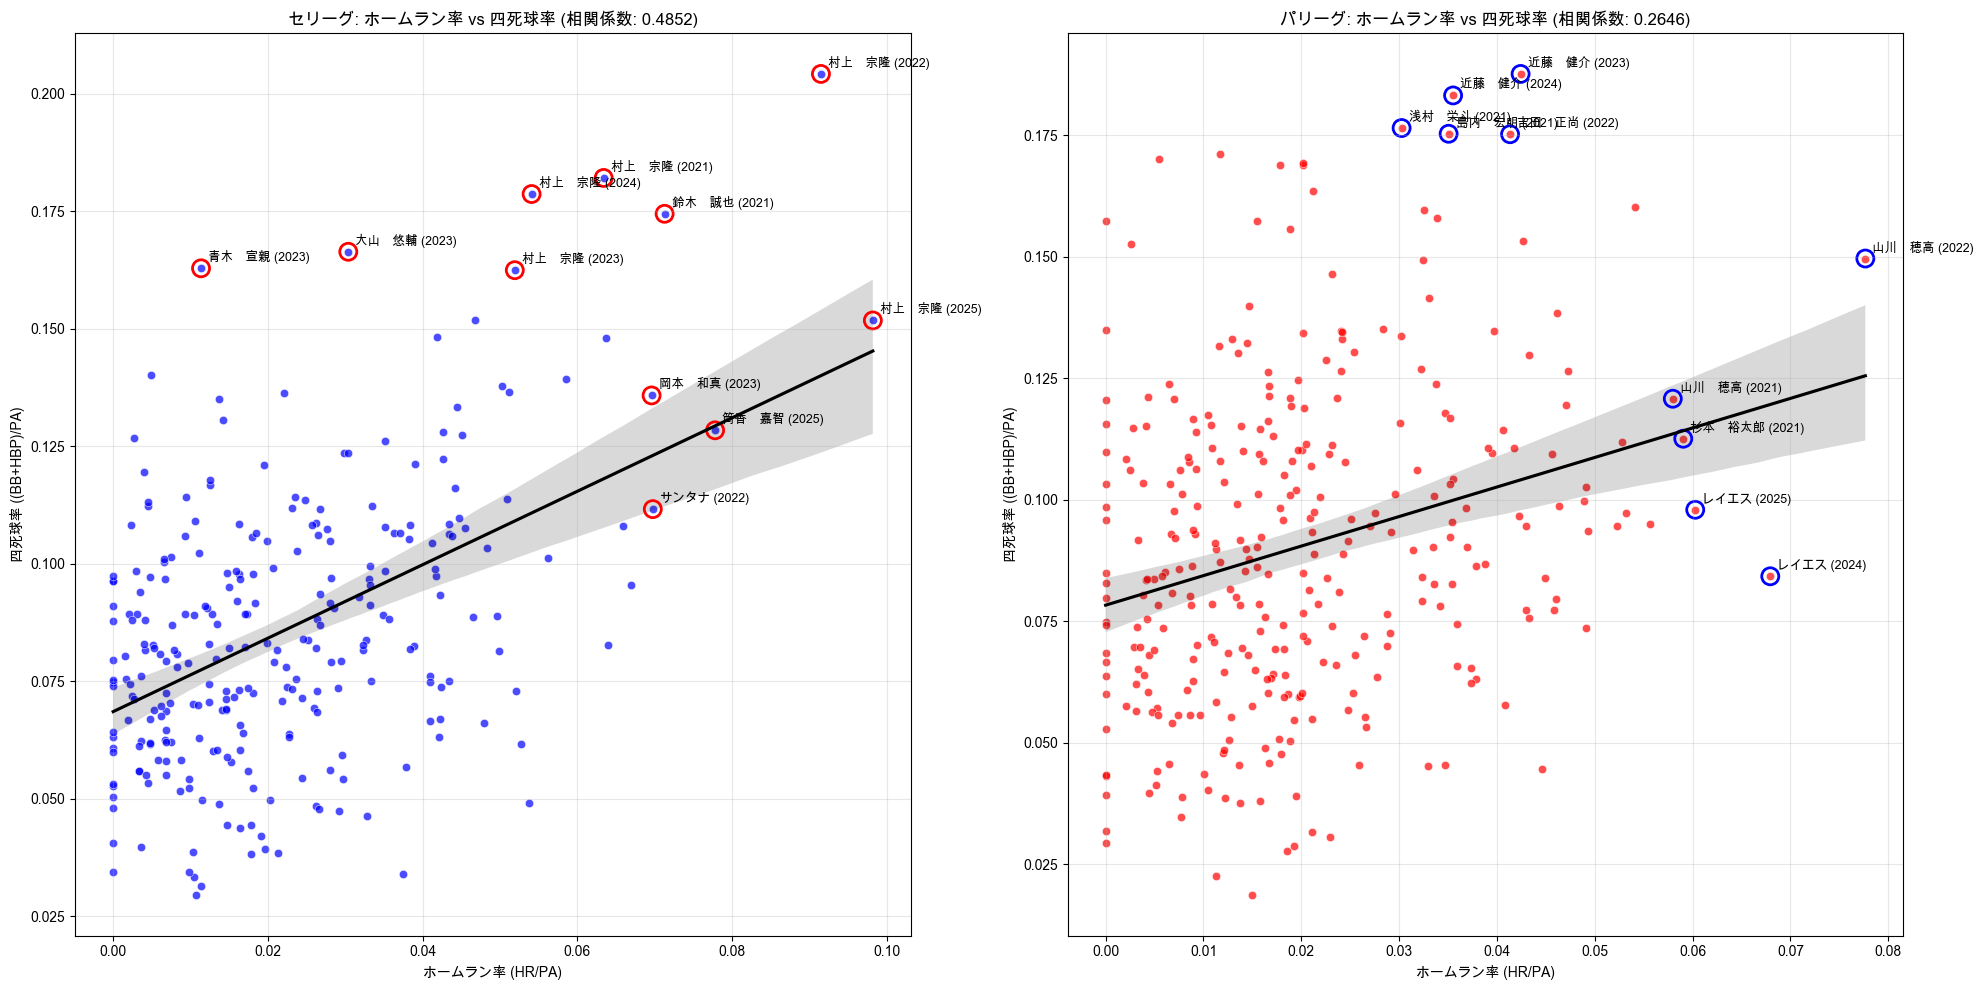

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# cp932エンコーディングを使用
df = pd.read_csv('stats_bat.csv', encoding='cp932')

# 必要な列を抽出
df_selected = df[['season_year', 'team_league_name', 'team_name', 'player_name', 'pa', 'ab', 'hr', 'bb', 'hbp']].copy()

# 200打席以上の選手だけを選択
df_filtered = df_selected[df_selected['pa'] >= 200].copy()

# ホームラン率(HR/PA)と四死球率((BB+HBP)/PA)を計算
df_filtered.loc[:, 'hr_rate'] = df_filtered['hr'] / df_filtered['pa']
df_filtered.loc[:, 'bb_hbp_rate'] = (df_filtered['bb'] + df_filtered['hbp']) / df_filtered['pa']

# リーグごとにデータを分割
central_df = df_filtered[df_filtered['team_league_name'] == 'セ・リーグ'].copy()
pacific_df = df_filtered[df_filtered['team_league_name'] == 'パ・リーグ'].copy()

# 相関係数の計算
central_corr = central_df['hr_rate'].corr(central_df['bb_hbp_rate'])
pacific_corr = pacific_df['hr_rate'].corr(pacific_df['bb_hbp_rate'])
total_corr = df_filtered['hr_rate'].corr(df_filtered['bb_hbp_rate'])

print(f"セリーグの相関係数: {central_corr:.4f}")
print(f"パリーグの相関係数: {pacific_corr:.4f}")
print(f"全体の相関係数: {total_corr:.4f}")

# 外れ値の検出（Z-scoreを使用）
central_df.loc[:, 'hr_rate_zscore'] = np.abs(stats.zscore(central_df['hr_rate']))
central_df.loc[:, 'bb_hbp_rate_zscore'] = np.abs(stats.zscore(central_df['bb_hbp_rate']))

pacific_df.loc[:, 'hr_rate_zscore'] = np.abs(stats.zscore(pacific_df['hr_rate']))
pacific_df.loc[:, 'bb_hbp_rate_zscore'] = np.abs(stats.zscore(pacific_df['bb_hbp_rate']))

# Z-score > 2.5を外れ値とする
central_outliers = central_df[(central_df['hr_rate_zscore'] > 2.5) | (central_df['bb_hbp_rate_zscore'] > 2.5)].copy()
pacific_outliers = pacific_df[(pacific_df['hr_rate_zscore'] > 2.5) | (pacific_df['bb_hbp_rate_zscore'] > 2.5)].copy()

# セリーグとパリーグで分けて、年度順、チーム名順、ホームラン率降順に並べる
print("\nセリーグの外れ値の選手 (年度順):")
central_outliers_sorted = central_outliers.sort_values(by=['season_year', 'team_name', 'hr_rate'], ascending=[True, True, False])
print(central_outliers_sorted[['season_year', 'team_name', 'player_name', 'pa', 'hr', 'bb', 'hbp', 'hr_rate', 'bb_hbp_rate']])

print("\nパリーグの外れ値の選手 (年度順):")
pacific_outliers_sorted = pacific_outliers.sort_values(by=['season_year', 'team_name', 'hr_rate'], ascending=[True, True, False])
print(pacific_outliers_sorted[['season_year', 'team_name', 'player_name', 'pa', 'hr', 'bb', 'hbp', 'hr_rate', 'bb_hbp_rate']])

# 2つのサブプロットを作成
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# セリーグのプロット（左側）- 色分け無し
sns.scatterplot(
    x='hr_rate', y='bb_hbp_rate', 
    data=central_df,
    color='blue',  # セリーグは青色で統一
    alpha=0.7,
    ax=axes[0]
)

# セリーグの回帰直線
sns.regplot(x='hr_rate', y='bb_hbp_rate', data=central_df, scatter=False, color='black', ax=axes[0])

# セリーグのタイトルと軸ラベル
axes[0].set_title(f'セリーグ: ホームラン率 vs 四死球率 (相関係数: {central_corr:.4f})')
axes[0].set_xlabel('ホームラン率 (HR/PA)')
axes[0].set_ylabel('四死球率 ((BB+HBP)/PA)')

# セリーグの外れ値をマーク
for i, row in central_outliers.iterrows():
    axes[0].scatter(row['hr_rate'], row['bb_hbp_rate'], color='none', s=150, edgecolor='red', linewidth=2)
    axes[0].annotate(f"{row['player_name']} ({row['season_year']})", 
                    (row['hr_rate'], row['bb_hbp_rate']),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)

# パリーグのプロット（右側）- 色分け無し
sns.scatterplot(
    x='hr_rate', y='bb_hbp_rate', 
    data=pacific_df,
    color='red',  # パリーグは赤色で統一
    alpha=0.7,
    ax=axes[1]
)

# パリーグの回帰直線
sns.regplot(x='hr_rate', y='bb_hbp_rate', data=pacific_df, scatter=False, color='black', ax=axes[1])

# パリーグのタイトルと軸ラベル
axes[1].set_title(f'パリーグ: ホームラン率 vs 四死球率 (相関係数: {pacific_corr:.4f})')
axes[1].set_xlabel('ホームラン率 (HR/PA)')
axes[1].set_ylabel('四死球率 ((BB+HBP)/PA)')

# パリーグの外れ値をマーク
for i, row in pacific_outliers.iterrows():
    axes[1].scatter(row['hr_rate'], row['bb_hbp_rate'], color='none', s=150, edgecolor='blue', linewidth=2)
    axes[1].annotate(f"{row['player_name']} ({row['season_year']})", 
                    (row['hr_rate'], row['bb_hbp_rate']),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9)

# グリッドを追加
axes[0].grid(True, alpha=0.3)
axes[1].grid(True, alpha=0.3)

# レイアウトの調整
plt.tight_layout()
plt.show()

## 外れ値のcsv作成

In [15]:
# 専用のフォルダを作成して外れ値データのCSVファイルを保存
import os

# outliers フォルダを作成（存在しない場合）
outliers_dir = "outliers"
if not os.path.exists(outliers_dir):
    os.makedirs(outliers_dir)
    print(f"'{outliers_dir}' フォルダを作成しました")

# 必要な列のみを選択
columns_to_save = ['season_year', 'team_league_name', 'team_name', 'player_name', 
                   'pa', 'ab', 'hr', 'bb', 'hbp', 'hr_rate', 'bb_hbp_rate']

# セリーグの外れ値をCSVに保存
central_outliers_path = os.path.join(outliers_dir, "central_league_outliers.csv")
central_outliers_sorted[columns_to_save].to_csv(central_outliers_path, index=False, encoding='cp932')
print(f"セリーグの外れ値を保存しました: {central_outliers_path}")

# パリーグの外れ値をCSVに保存
pacific_outliers_path = os.path.join(outliers_dir, "pacific_league_outliers.csv")
pacific_outliers_sorted[columns_to_save].to_csv(pacific_outliers_path, index=False, encoding='cp932')
print(f"パリーグの外れ値を保存しました: {pacific_outliers_path}")

# すべての外れ値を1つのファイルにまとめる
all_outliers = pd.concat([central_outliers_sorted, pacific_outliers_sorted])
all_outliers_sorted = all_outliers.sort_values(
    by=['team_league_name', 'season_year', 'team_name', 'hr_rate'], ascending=[True, True, True, False])
all_outliers_path = os.path.join(outliers_dir, "all_outliers.csv")
all_outliers_sorted[columns_to_save].to_csv(all_outliers_path, index=False, encoding='cp932')
print(f"全リーグの外れ値を保存しました: {all_outliers_path}")

print(f"\nセリーグの外れ値の数: {len(central_outliers_sorted)}")
print(f"パリーグの外れ値の数: {len(pacific_outliers_sorted)}")
print(f"全体の外れ値の数: {len(all_outliers_sorted)}")

セリーグの外れ値を保存しました: outliers/central_league_outliers.csv
パリーグの外れ値を保存しました: outliers/pacific_league_outliers.csv
全リーグの外れ値を保存しました: outliers/all_outliers.csv

セリーグの外れ値の数: 11
パリーグの外れ値の数: 10
全体の外れ値の数: 21
